In [74]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import math
from sklearn.model_selection import train_test_split
from geopy.geocoders import Nominatim

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geoplot

import matplotlib.pyplot as plt

# Importación del CSV

In [75]:
datapath = 'data'
df = pd.read_csv(os.path.join(datapath, 'uber_fares.csv'))
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...
199994,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199995,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199996,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199997,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [76]:
#df.dtypes

# Preprocesamiento de los datos

In [77]:
# Sustituimos las fechas por timestamps
# df['pickup_timestamp'] = df['pickup_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC').timestamp())
df['pickup_timestamp'] = df['pickup_datetime'].apply(lambda x: pd.Timestamp(x))
df['pickup_monthday'] = df['pickup_timestamp'].apply(lambda x: x.day)
df['pickup_weekday'] = df['pickup_timestamp'].apply(lambda x: x.weekday)
df.drop('pickup_datetime', axis=1, inplace=True)
df.drop('pickup_timestamp', axis=1, inplace=True)

### Cálculo de la distancia mediante el semiverseno
El semiverseno se utiliza para calcular la distancia en la superfície de una esfera dadas las coordenadas de los puntos en la misma.

Fórmula del semiverseno utilizada: 

$$ semiversin\left({d\over R}\right) = semiversin(φ_1 - φ_2) + cos(φ_1) cos(φ_2) semiversin(\small \Delta λ) $$

Donde:
* $d$ es la distancia entre dos los dos puntos
* $R$ es el radio de la esfera
* $φ_1$ es la latitud del punto 1
* $φ_2$ es la latitud del punto 2
* $\small \Delta λ$ es la la diferencia de longitudes de los puntos

In [78]:
# Función que calcula la distancia en la tierra entre dos pares de coordenadas usando el semiverseno, devuelve la distancia en metros
def coordsToDistance(long1: float, lat1: float, long2: float, lat2: float):
    # Radio de la tierra aprox
    R = 6367000
    # Grados a radianes
    degToRad = math.pi / 180

    distLong = (long2 - long1) * degToRad
    distLat = (lat1 - lat2) * degToRad
    
    a = (math.sin(distLat / 2) ** 2) + (math.cos(lat1 * degToRad) * math.cos(lat2 * degToRad) * (math.sin(distLong / 2) ** 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d


In [79]:
# Reemplazamos las columnas de las coordenaas con la distancia
coords:np.ndarray = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].to_numpy()
distances = np.apply_along_axis(lambda x: coordsToDistance(x[0], x[1], x[2], x[3]), 1, coords)
df.insert(2, 'distance_run', pd.Series(distances))
# df = df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1 )
df.head()



,fare_amount,pickup_longitude,distance_run,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_monthday,pickup_weekday
0,7.5,-73.999817,1682.265887,40.738354,-73.999512,40.723217,1,7,3
1,7.7,-73.994355,2456.046898,40.728225,-73.994710,40.750325,1,17,4
2,12.9,-74.005043,5033.215126,40.740770,-73.962565,40.772647,1,24,0
3,5.3,-73.976124,1660.640179,40.790844,-73.965316,40.803349,3,26,4
4,16.0,-73.925023,4472.640074,40.744085,-73.973082,40.761247,5,28,3


### Limpieza de datos
Datos a eliminar:
* Viajes con mas de 6 pasajeros
* Viajes muy cortos o muy largos
* Viajes precios desorbitados
* etc...

In [80]:
df.drop(df[df['distance_run'] > 60000].index, inplace=True)
df.drop(df[df['distance_run'] < 10].index, inplace=True)
df.drop(df[df['fare_amount'] > 1000].index, inplace=True)
df.drop(df[df['fare_amount'] < 1].index, inplace=True)
df.drop(df[df['pickup_latitude'] > 50].index, inplace=True)
df.drop(df[df['pickup_latitude'] < 10].index, inplace=True)
df.drop(df[df['dropoff_latitude'] > 50].index, inplace=True)
df.drop(df[df['dropoff_latitude'] < 10].index, inplace=True)

## Comprobamos que la posición de todos los datos está en nueva york

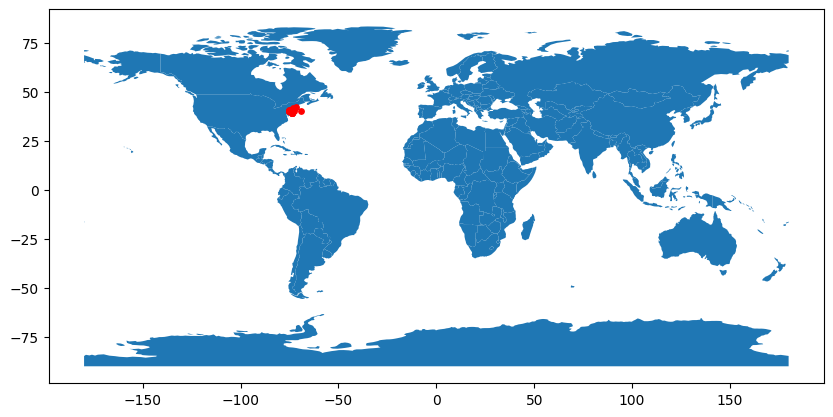

In [81]:
geometry = [Point(xy) for xy in zip(df['pickup_longitude'], df['pickup_latitude'])]
crs={'init':'epsg:4326'}
gdf = GeoDataFrame(geometry=geometry)  
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [82]:
df = df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1 )

In [83]:
df.head()

,fare_amount,distance_run,passenger_count,pickup_monthday,pickup_weekday
0,7.5,1682.265887,1,7,3
1,7.7,2456.046898,1,17,4
2,12.9,5033.215126,1,24,0
3,5.3,1660.640179,3,26,4
4,16.0,4472.640074,5,28,3


# Creación de los conjuntos de test y train

In [84]:
# x = pd.DataFrame(df['fare_amount'])
# x = pd.DataFrame(df.iloc[:, 0])
# y = df.drop('fare_amount', axis=1)
# y = df.iloc[:, 1:]

x = df.drop('fare_amount', axis=1)
y = pd.DataFrame(df['fare_amount'])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2)

#Mostrar las caracerísticas de los arrays
print('Conjuntos de datos:')
print('xTrain: ' + str(xTrain.shape))
print('xTest: ' + str(xTest.shape))
print('yTrain: ' + str(yTrain.shape))
print('yTest: ' + str(yTest.shape))

Conjuntos de datos:
xTrain: (154564, 4)
xTest: (38641, 4)
yTrain: (154564, 1)
yTest: (38641, 1)


# Regresión lineal

In [85]:
from linReg import LinRegClassifier
import matplotlib.pyplot as plt

In [86]:
classifier = LinRegClassifier(xTrain, yTrain, numIter=5, lRate=0.001)
classifier.train()

[1.35538563e+05 3.83780822e+01 3.55034744e+02 6.89932176e+01
 2.25771627e+01]
[-1.35538563e+02 -3.83780822e-02 -3.55034744e-01 -6.89932176e-02
 -2.25771627e-02]

[6.52688781e+09 1.54366038e+06 1.43121331e+07 2.80616010e+06
 9.09981991e+05]
[-6.52702335e+06 -1.54369876e+03 -1.43124881e+04 -2.80622909e+03
 -9.10004568e+02]

[3.14303335e+14 7.43348273e+10 6.89199104e+11 1.35130424e+11
 4.38201035e+10]
[-3.14309862e+11 -7.43363710e+07 -6.89213416e+08 -1.35133230e+08
 -4.38210135e+07]

[1.51353278e+19 3.57960560e+15 3.31884940e+16 6.50722737e+15
 2.11016415e+15]
[-1.51356421e+16 -3.57967994e+12 -3.31891832e+13 -6.50736250e+12
 -2.11020797e+12]

[7.28844153e+23 1.72376485e+20 1.59819728e+21 3.13356584e+20
 1.01615295e+20]
[-7.28859289e+20 -1.72380065e+17 -1.59823047e+18 -3.13363091e+17
 -1.01617405e+17]



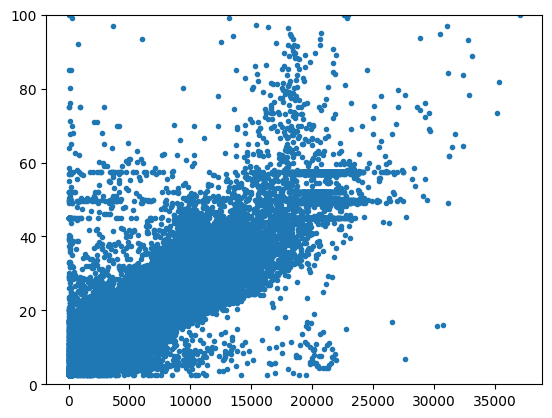

In [87]:
# Distance run

plt.scatter(xTrain['distance_run'].to_numpy(), yTrain, marker=".")
plt.ylim([0,np.max(yTrain.to_numpy())])
a = np.linspace(0, np.max(xTrain.to_numpy()[:, 1]), int(np.max(xTrain.to_numpy()[:, 1]) / 100))
